In [2]:
'''
Code for piping the majority and minority classes to their appropriate models, and running the models
'''
import pandas as pd
import numpy as np 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#Other model will go here as well
import LACER as lc
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sgcrf import SparseGaussianCRF
from joblib import dump, load
import pickle
from sklearn.pipeline import Pipeline

#Features to use in our model, c = categorical, d = numeric
c = ['AssignTo', 'RequestType', 'RequestSource', 'Month', 'Anonymous', 'CreatedByUserOrganization']
d = ['Latitude', 'Longitude']
    
#Slightly editied lacer funcions
def preprocessing(df, start_date, end_date):
    """
    Filters dataframe by specified start and end_dates and runs CleanedFrame on it.  
    """ 
    #Filter dataframe by dates 
    df = df[(df['Just Date'] >= start_date) & (df['Just Date'] <= end_date)]
    df = lc.CleanedFrame(df)
    return df

def lacer(df, df1, train_start_date, train_end_date, test_start_date, test_end_date, request_type, CD, predictor_num):
    """
    Trains 2 GCRF models on data from specified CD and Request Type which is assigned to fulfill request. 
    Uses specified start and end dates for training and testing to creat train and test sets. 
    """

    #Create Training and Testing Sets
    dftrain = preprocessing(df, train_start_date, train_end_date)
    dftrain = dftrain.reset_index(drop = True)
    dftest = preprocessing(df1, test_start_date, test_end_date)
    dftest = dftest.reset_index(drop = True)

    #Reserve test set for training on all 3 models.
    
    y_train, y_test = lc.CreateTestSet(dftest, predictor_num)
    y_test = y_test.reshape((-1, 1))
   

    ## 2 Models
    #Model1: CD
    modelCD = SparseGaussianCRF(lamL=0.1, lamT=0.1, n_iter=10000)
    dftrainCD = dftrain[dftrain['CD'] == CD].reset_index(drop = True)
    
    
    X_trainCD, X_testCD = lc.CreateTrainSet(dftrainCD, predictor_num)
    X_testCD = X_testCD.reshape((-1, 1))
    modelCD.fit(X_trainCD, X_testCD)

    y_predCD = modelCD.predict(y_train)

    #Model2: Request_type
    modelRT = SparseGaussianCRF(lamL=0.1, lamT=0.1, n_iter=10000)
    dftrainRT = dftrain[dftrain['RequestType'] == request_type].reset_index(drop = True)

    X_trainRT, X_testRT = lc.CreateTrainSet(dftrainRT, predictor_num)
    X_testRT = X_testRT.reshape((-1, 1))

    modelRT.fit(X_trainRT, X_testRT)

    y_predRT = modelRT.predict(y_train)


    #Average out all predictions
    y_predFinal = (y_predCD + y_predRT )/2

    # Return models
    return modelCD, modelRT

"""
Retu whether or not a number is greater than 11. 
"""
def gelev(val): 
    if val <= 11: 
        return 0
    else: 
        return 1

'''
Preprocessing function. Takes in the file path to the data and loads it in a DataFrame, 
then calcuates the elapsed days per request and marks them as more than or less than eleven days. 
Then it encodes the appropriate values and returns the train data, labels, and the formatted dataframe.
If formatted is False, it will convert the Just Date column into datetime objects
If encode is false, it requires that the onehotencoder has already been dumped into a joblib file,
so make sure that this has been run once on all the data with encode equal to true.
'''
def preprocess(df, formatted=False,encode=False):
    if not formatted:
        df['Just Date'] = df['Just Date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
    df['Eleven'] = df['ElapsedDays'].apply(gelev, 0)
    df['Month'] = df['Just Date'].dt.month_name()
    #Put desired columns into dataframe, drop nulls. 
    dfn = df.filter(items = c + d + ['ElapsedDays','Just Date','CreatedDate','ClosedDate','CD'])
    dfn = dfn.dropna()
    #Separate data into explanatory and response variables
    XCAT = dfn.filter(items = c).values
    XNUM = dfn.filter(items = d).values
    y = dfn['ElapsedDays'] <= 11
    #Encode cateogrical data and merge with numerical data
    if encode:
        onehotencoder = OneHotEncoder()
        print(XCAT.shape)
        onehotencoder.fit_transform(XCAT)
        #XCAT = onehotencoder.fit_transform(XCAT).toarray()
        X = np.concatenate((XCAT, XNUM), axis=1)
        print()
        dump(onehotencoder,'onehot.joblib')
        #pickle.dump(onehotencoder, open("encoder.pkl", "wb"))
    else:
        onehotencoder = load('onehot.joblib')
        XCAT = onehotencoder.transform(XCAT).toarray()
        X = np.concatenate((XCAT, XNUM), axis=1)
    return X,y, dfn

'''
Preprocess a request given as a dataframe
'''
def preprocess_request(df):
    dfn = df.filter(items = c + d)
    dfn = dfn.dropna()
    #Separate data into explanatory and response variables
    XCAT = dfn.filter(items = c).values
    XNUM = dfn.filter(items = d).values
    y = None
    #Encode cateogrical data and merge with numerical data
    onehotencoder = load('onehot.joblib')
    XCAT = onehotencoder.transform(XCAT).toarray()
    X = np.concatenate((XCAT, XNUM), axis=1)
    return X, dfn

'''
Runs the model that classifies each request as more than or less than/equal to 11 days. 
Parameters are the hyperparameters for the model itself, and the train data and labels.
'''
def estimation_model(estimators, depth,X,y):    
    rf = RandomForestClassifier(n_estimators = estimators, max_depth = depth)
    print('creating train, test, val split')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)
    #Train Model on 3 yrs data on
    print('training model')
    rf.fit(X_train, y_train)
    #Test model
    print('testing model')
    y_vpred = rf.predict(X_val)
    print('dump to pickle')
    pickle.dump(rf, open('randomForest.pkl', 'wb'))
    #Print Accuracy Function results
    print("Accuracy:",metrics.accuracy_score(y_val, y_vpred))
    print("Precision, Recall, F1Score:",metrics.precision_recall_fscore_support(y_val, y_vpred, average = 'binary'))
    return rf

'''
Takes a file path to the data, runs the appropriate preprocessing steps, and uses the model to classify everything into the majority and minority class. Returns a dataframe with the majority class and a separate one with the minority class.
'''
def split_to_models(df,formatted=False, encode=True):
    print('Calculating train data and labels')
    X, y, df = preprocess(df,formatted)
    print('Creating 11 day classifier')
    #Train on 3 yrs before data
    print(X.shape)
    model_eleven = estimation_model(50,20,X,y)
    df['LessEqualEleven'] = model_eleven.predict(X)
    df['LessEqualEleven'] = df['LessEqualEleven'].apply(lambda x: int(x))
    df_sgcrf = df[df['LessEqualEleven'] == 1.0]
    df_other = df[df['LessEqualEleven'] == 0.0]
    return df_sgcrf, df_other

'''
Given a start date, it will train the classifier on data 3 years before 10 weeks before the start date, then 
train the sgcrf model with 10 weeks of data from before the start date, then predict using the fifty most recent requests
from the start date.
'''
#Demo code
def create_models(df,start_date, request_type, CD, predictor_num):
    start = datetime.strptime(start_date,'%Y-%m-%d')
    #Preprocess data
    X, y, dfn = preprocess(df,encode=True)
    #Sort into past three years
    df_three = dfn[(dfn['Just Date'] <= start-timedelta(weeks=11)) &
                   (dfn['Just Date'] >= start-timedelta(weeks=11)+relativedelta(years=-3) )]
    #Run dataframe through the classifier and get all requests less than or equal to 11 days
    df_sgcrf,ignore = split_to_models(df_three,True)
    #Get last 50 requests
    dff = df_sgcrf.copy().tail(50).reset_index(drop=True)
    dff['ElapsedHours'] = dff.apply(lambda x: lc.elapsedHours(x['CreatedDate'],x['ClosedDate']),axis=1)
    #Last 50 elapsedhours values
    fifty = dff['ElapsedHours'].values
    #Dump to npy file to be used by website backend
    np.save(open('previousfifty.npy','wb'),fifty)
    #Date of the 50th request from the end
    train_end_date = df_sgcrf.iloc[-50]['Just Date']
    #Send to LACER
    modelCD, modelRT = lacer(df_sgcrf.copy(),df_sgcrf.copy(), train_end_date - timedelta(weeks=10), train_end_date, train_end_date - timedelta(weeks=10), train_end_date, request_type, CD, predictor_num)
    #Dump to pickle file
    pickle.dump(modelCD, open('modelCD.pkl','wb'))
    pickle.dump(modelRT, open('modelRT.pkl','wb'))

'''
Beginning code to update the model after requests have been made.
'''
def update_model(requests,modelCD,modelRT,modelMin):
    df_request = pd.DataFrame(data=requests,columns=c+d)
    X, y, df = preprocess(df_request)
    df_sgcrf = df[df['ElapsedDays'] <= 11.0]
    df_other = df[df['ElapsedDays'] > 11.0]
    modelCD.fit(np.asarray(df_sgcrf['CD']),np.asarray(df_sgcrf['ElapsedDays']))
    modelRT.fit(np.asarray(df_sgcrf['RequestType']),np.asarray(df_sgcrf['ElapsedDays']))
    #modelMin.fit will go here
    #dump back to pickle - or we can just return the models themselves
    pickle.dump(modelCD, open('modelCD.pkl'), 'wb')
    pickle.dump(modelRT, open('modelRT.pkl'), 'wb')

In [2]:
# Run this to generate the pickle files for the random forest classifier, the 2 models, 
# the one hot encoder joblib(generated in preprocess), and the last fifty requests from the start data as an npy file.
df_requests = pd.read_csv('2020service.csv')
df_requests = df_requests[df_requests['RequestSource'] != 'Driver Self Report']
create_models(df_requests,'2020-10-01','Graffiti Removal',5,50)

C:\Users\ngeta\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (10,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1462397, 6)

Calculating train data and labels


C:\Users\ngeta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ngeta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Creating 11 day classifier
(1215942, 123)
creating train, test, val split
training model
testing model
dump to pickle
Accuracy: 0.9558419129174355
Precision, Recall, F1Score: (0.9649652897837594, 0.9890678502104643, 0.9768679201591862, None)


C:\Users\ngeta\p-requests\311_Requests_Model\LACER.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['ElapsedHours'] = df.apply(lambda x: elapsedHours(x['CreatedDate'],x['ClosedDate']),axis=1)
C:\Users\ngeta\p-requests\311_Requests_Model\LACER.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['ClosedDate'] = df['ClosedDate'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p'))
C:\Users\ngeta\p-requests\311_Requests_Model\LACER.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [7]:
df_requests = pd.read_csv('2020service.csv')
df_requests = df_requests[df_requests['RequestSource'] != 'Driver Self Report']
X,y, dfn = preprocess((df_requests),encode=True)

C:\Users\ngeta\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (10,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1462397, 6)



In [11]:
df_requests = pd.read_csv('2020service.csv')

KeyboardInterrupt: 

In [10]:
dfn.Month.unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September'], dtype=object)

In [152]:
start = datetime.strptime('2019-12-01','%Y-%m-%d')
X, y, dfn = preprocess(pd.read_csv('fservice.csv'),encode=True)
 #past three years
df_three = dfn[(dfn['Just Date'] <= start-timedelta(weeks=11)) &
                (dfn['Just Date'] >= start-timedelta(weeks=11)+relativedelta(years=-2) )]
df_sgcrf,ignore = split_to_models(df_three,True)
train_end_date = df_sgcrf.iloc[-50]['Just Date']

C:\Users\ngeta\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (10,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(679112, 6)

Calculating train data and labels
Creating 11 day classifier
(679112, 111)
creating train, test, val split
training model
testing model
dump to pickle
Accuracy: 0.9585120285666955
Precision, Recall, F1Score: (0.9686860830236511, 0.9877894736842106, 0.9781445138269402, None)


In [169]:
df_sgcrf.head()

,AssignTo,RequestType,RequestSource,Month,Anonymous,CreatedByUserOrganization,Latitude,Longitude,ElapsedDays,Just Date,CreatedDate,ClosedDate,CD,LessEqualEleven
2340578,NC,Bulky Items,Self Service,January,N,Self Service_SAN,34.082258,-118.312461,3,2019-01-01,01/01/2019 12:02:00 AM,01/04/2019 11:03:00 AM,4.0,1
2340580,WVA,Graffiti Removal,Self Service,January,N,Self Service,34.236888,-118.536385,2,2019-01-01,01/01/2019 12:10:00 AM,01/03/2019 12:27:00 AM,12.0,1
2340581,WV,Illegal Dumping Pickup,Self Service,January,N,Self Service,34.230222,-118.539758,6,2019-01-01,01/01/2019 12:19:00 AM,01/07/2019 09:39:00 AM,12.0,1
2340582,WVA,Graffiti Removal,Self Service,January,N,Self Service,34.235078,-118.536392,2,2019-01-01,01/01/2019 12:28:00 AM,01/03/2019 12:28:00 AM,12.0,1
2340583,WVA,Graffiti Removal,Self Service,January,N,Self Service,34.239704,-118.523064,2,2019-01-01,01/01/2019 12:32:00 AM,01/03/2019 04:27:00 PM,12.0,1


In [191]:
dff = df_sgcrf.copy().tail(50).reset_index(drop=True)
dff['ElapsedHours'] = dff.apply(lambda x: lc.elapsedHours(x['CreatedDate'],x['ClosedDate']),axis=1)
fifty = dff['ElapsedHours'].values

In [207]:
np.save(open('previousfifty.npy','wb'),fifty)

In [3]:
a = np.load(open('previousfifty.npy','rb'))
a

array([ 16.87361111,  12.4125    , 129.1325    ,  39.90722222,
         8.385     ,  10.89694444, 107.19444444,  17.26333333,
       133.45138889,  72.7525    , 114.03305556,  10.865     ,
        17.99833333,  16.08138889,  88.67666667, 105.08583333,
         8.80861111,  13.59305556, 129.20055556, 112.40083333,
       144.55638889, -23.45611111,  16.06916667,  12.50944444,
        12.73777778,  11.18888889,  15.65194444,  80.22694444,
        17.04777778,  15.53361111,  16.15444444,  15.27305556,
        16.14027778,  14.51972222,  16.03583333,  87.40166667,
        80.27611111, 294.07472222,  89.53222222,  14.50444444,
       108.68333333,  80.76861111,  15.51638889,  85.61611111,
         7.68527778, 155.09527778, 127.21833333,  83.29722222,
       138.79638889,  26.59305556])

In [183]:
dff.head()

,AssignTo,RequestType,RequestSource,Month,Anonymous,CreatedByUserOrganization,Latitude,Longitude,ElapsedDays,Just Date,CreatedDate,ClosedDate,CD,LessEqualEleven,ElapsedHours
3030758,EV,Bulky Items,Call,July,N,BOS,34.178507,-118.362879,2,2019-07-21,07/21/2019 08:11:00 PM,07/23/2019 09:28:00 AM,2.0,1,37.283333
3030759,NC,Illegal Dumping Pickup,Call,July,N,BOS,34.056775,-118.297845,5,2019-07-21,07/21/2019 08:12:00 PM,07/26/2019 05:14:00 PM,10.0,1,117.033333
3030760,EV,Bulky Items,Call,July,N,BOS,34.179279,-118.363509,2,2019-07-21,07/21/2019 08:12:00 PM,07/23/2019 09:27:00 AM,2.0,1,37.250000
3030761,NEGB_ELA,Graffiti Removal,Mobile App,July,N,Self Service,34.139627,-118.202154,1,2019-07-21,07/21/2019 08:14:00 PM,07/22/2019 09:43:00 AM,14.0,1,13.483333
3030762,NC,Bulky Items,Call,July,N,BOS,34.057328,-118.297529,5,2019-07-21,07/21/2019 08:14:00 PM,07/26/2019 03:46:00 PM,10.0,1,115.533333


In [91]:
XCAT = dfn.filter(items = c).values
XCAT.shape

(679112, 6)

In [89]:
from dateutil.relativedelta import relativedelta
start_date = '2019-12-01'
start = datetime.strptime(start_date,'%Y-%m-%d')
df_three = dfn[(dfn['Just Date'] <= start-timedelta(weeks=11)) &
                   (dfn['Just Date'] >= start-timedelta(weeks=11)+relativedelta(years=-1) )]

In [90]:
df_three.head()

,AssignTo,RequestType,RequestSource,Anonymous,CreatedByUserOrganization,CD,Latitude,Longitude,ElapsedDays,Just Date,CreatedDate,ClosedDate
2340578,NC,Bulky Items,Self Service,N,Self Service_SAN,4.0,34.082258,-118.312461,3,2019-01-01,01/01/2019 12:02:00 AM,01/04/2019 11:03:00 AM
2340580,WVA,Graffiti Removal,Self Service,N,Self Service,12.0,34.236888,-118.536385,2,2019-01-01,01/01/2019 12:10:00 AM,01/03/2019 12:27:00 AM
2340581,WV,Illegal Dumping Pickup,Self Service,N,Self Service,12.0,34.230222,-118.539758,6,2019-01-01,01/01/2019 12:19:00 AM,01/07/2019 09:39:00 AM
2340582,WVA,Graffiti Removal,Self Service,N,Self Service,12.0,34.235078,-118.536392,2,2019-01-01,01/01/2019 12:28:00 AM,01/03/2019 12:28:00 AM
2340583,WVA,Graffiti Removal,Self Service,N,Self Service,12.0,34.239704,-118.523064,2,2019-01-01,01/01/2019 12:32:00 AM,01/03/2019 04:27:00 PM


In [ ]:
    dfn = df.filter(items = c + d)
    dfn = dfn.dropna()
    #Separate data into explanatory and response variables
    XCAT = dfn.filter(items = c).values
    XNUM = dfn.filter(items = d).values
    y = None
    #Encode cateogrical data and merge with numerical data
    onehotencoder = load('onehot.joblib')
    XCAT = onehotencoder.transform(XCAT).toarray()
    X = np.concatenate((XCAT, XNUM), axis=1)
    return X, dfn

In [198]:
features = ['WLA','Bulky Items','Self Service','January','N','Self Service',34.0144110617, -118.444726595]
column_names = ['AssignTo', 'RequestType', 'RequestSource', 'Month', 'Anonymous', 'CreatedByUserOrganization','Latitude','Longitude']
dictionary = dict(zip(column_names,features))
df_request = pd.DataFrame(columns= column_names)
for key in dictionary: 
    df_request.at[0, key] = dictionary[key] 
X, dfn = preprocess_request(df_request)

In [144]:
X

array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,
        0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 1.0, 0.0, 34.0144110617, -118.444726595]],
      dtype=object)

In [209]:
modelRT = pickle.load(open('modelCD.pkl', 'rb'))
#formatted_request = np.array([fifty,dfn['ElapsedHours'][0]])
modelRT.predict(a)/24

array([1.72038993])

In [199]:
dfn

,AssignTo,RequestType,RequestSource,Month,Anonymous,CreatedByUserOrganization,Latitude,Longitude
0,WLA,Bulky Items,Self Service,January,N,Self Service,34.0144,-118.445


In [92]:
XCAT = dfn.filter(items = c).values
XNUM = dfn.filter(items = d).values

In [102]:
XCAT

array([['WLA', 'Bulky Items', 'Self Service', 'January', 'N',
        'Self Service']], dtype=object)

In [99]:
onehotencoder = load('onehot.joblib')
XCAT = onehotencoder.transform(XCAT.reshape((7,-))).toarray()

ValueError: cannot reshape array of size 6 into shape (7,)

In [ ]:
df = pd.read_csv('fservice.csv')

In [140]:
#Number of requests that are under or equal to 11 days
df_under = df[df['ElapsedDays'] <= 11]
df_under.shape[0]

2890754

In [141]:
#Number of requests that are more than 11 days
df_over = df[df['ElapsedDays'] > 11]
df_over.shape[0]

140059

In [142]:
df_over.shape[0] / (df_over.shape[0] + df_under.shape[0])
#Very small

0.046211693034179276

Finding the distribution of elapsed days between 50 requests

In [18]:
df_requests = pd.read_csv('2020service.csv')

In [83]:
rts = df_requests.RequestType.unique()
rts

array(['Other', 'Graffiti Removal', 'Bulky Items', 'Dead Animal Removal',
       'Metal/Household Appliances', 'Single Streetlight Issue',
       'Illegal Dumping Pickup', 'Feedback', 'Multiple Streetlight Issue',
       'Report Water Waste', 'Homeless Encampment', 'Electronic Waste'],
      dtype=object)

In [93]:
df_requests.RequestType.value_counts()

Bulky Items                   1904013
Graffiti Removal              1061675
Illegal Dumping Pickup         335434
Metal/Household Appliances     321180
Electronic Waste               141150
Homeless Encampment            128126
Dead Animal Removal             82223
Other                           59298
Single Streetlight Issue        34239
Multiple Streetlight Issue      18948
Report Water Waste               4150
Feedback                         1840
Name: RequestType, dtype: int64

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline

KeyboardInterrupt: 

 
 Other


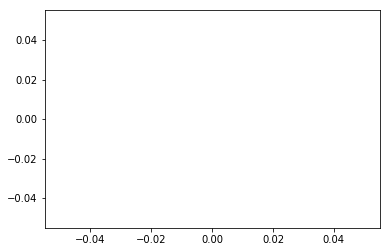

ValueError: Cannot describe a DataFrame without columns

In [107]:
for rt in rts:
    df_rt = df_requests[df_requests['RequestType'] == rt]['CreatedDate'].apply(lambda x: datetime.strptime(x,'%m/%d/%Y %H:%M:%S %p')).reset_index(drop=True)
    y = []
    print(f' \n {rt}')
    for j in range(50,len(df_rt)):
        try:
            if df_rt.iloc[j] < datetime.now():
                continue
            diff = df_rt.iloc[j] - df_rt.iloc[j-50]
            if diff.days != 0:
                y.append(abs(diff.days + diff.seconds/86400))
            else:
                y.append(abs(diff.seconds/86400))
        except:
            print(rt)
            print(j)
            break
    plt.plot([i for i in range(len(y))] , y)
    plt.show()
    df = pd.DataFrame(y)
    print(df.describe())
    

In [102]:
y

[4.860416666666667,
 6.007638888888889,
 0.009027777777777777,
 0.06597222222222222,
 0.008333333333333333,
 14.215277777777779,
 1.8027777777777778,
 2.9291666666666667,
 1.80625,
 1.8034722222222221,
 2.0722222222222224,
 2.025,
 2.0194444444444444,
 1.0763888888888888,
 2.0972222222222223,
 5.238888888888889,
 0.9486111111111111,
 6.067361111111111,
 0.002777777777777778,
 1.167361111111111,
 0.7270833333333333,
 0.9326388888888889,
 0.011805555555555555,
 14.16875,
 0.8743055555555556,
 0.9201388888888888,
 13.031944444444445,
 2.0152777777777775,
 0.7666666666666667,
 1.1305555555555555,
 2.8604166666666666,
 1.1861111111111111,
 2.7180555555555554,
 1.2527777777777778,
 6.964583333333334,
 14.342361111111112,
 0.20486111111111116,
 1.79375,
 0.23402777777777772,
 1.0458333333333334,
 0.008333333333333333,
 3.073611111111111,
 3.15625,
 0.002083333333333326,
 0.006944444444444444,
 5.207638888888889,
 0.9270833333333334,
 13.175,
 0.9243055555555556,
 1.0333333333333332,
 4.301388